# Visualization of Data

### 1. Total Solar Irradiance (TSI)

In [299]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy.optimize import curve_fit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [247]:
# Directory containing the TSI files
data_dir = 'tsi_monthly'

# Find all NetCDF files in the directory
file_paths = sorted(glob(os.path.join(data_dir, 'tsi_*.nc')))

# Initialize an empty list to store DataFrames
data_frames = []

# Loop through each file and load the data
for file_path in file_paths:
    # Open the NetCDF file
    dataset = xr.open_dataset(file_path)
    
    # Convert the dataset to a Pandas DataFrame and reset the index
    df = dataset.to_dataframe().reset_index()
    
    # Ensure the 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Append the DataFrame to the list
    data_frames.append(df)

all_data = pd.concat(data_frames, ignore_index=True)
print(all_data.head())

        time  bounds          TSI   TSI_UNC  time_bnds
0 2014-01-15       0  1361.692383  0.152830 2014-01-01
1 2014-01-15       1  1361.692383  0.152830 2014-02-01
2 2014-02-15       0  1361.590088  0.173391 2014-02-01
3 2014-02-15       1  1361.590088  0.173391 2014-03-01
4 2014-03-15       0  1362.293213  0.133309 2014-03-01


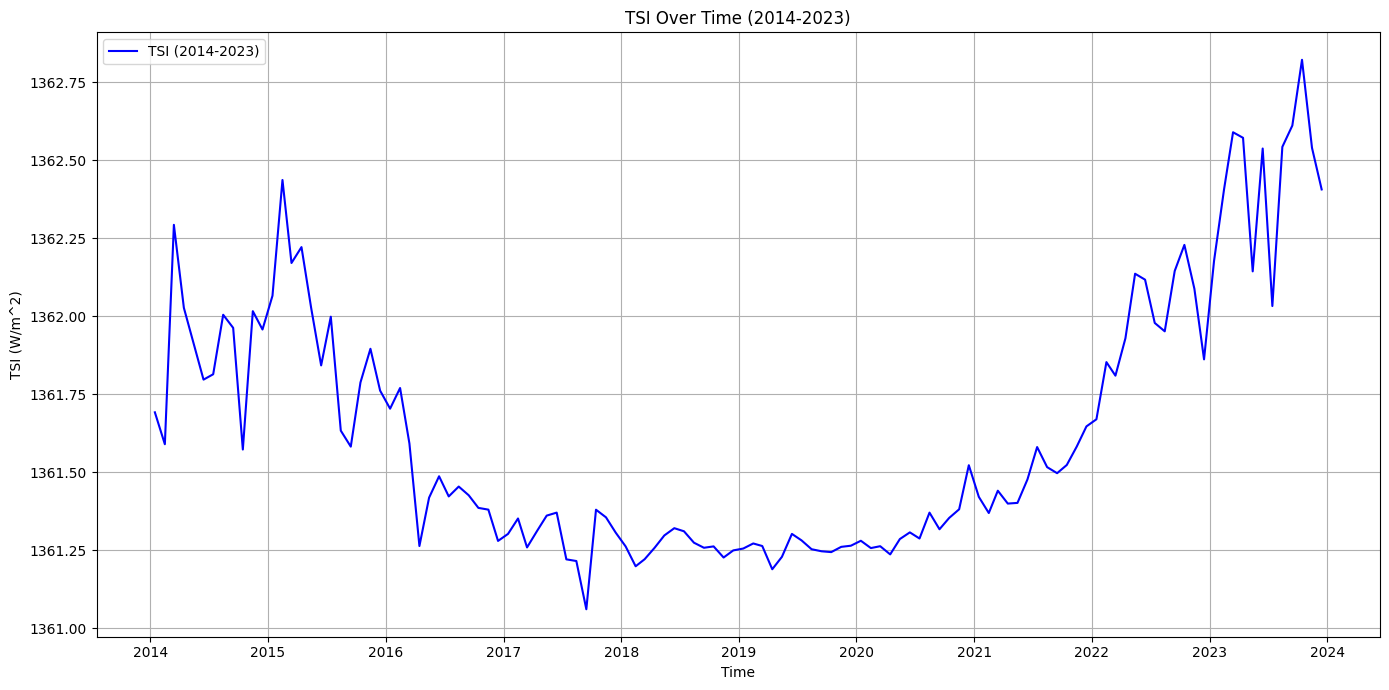

In [248]:
# Extract time and TSI for plotting
time = all_data['time']
tsi = all_data['TSI']

# Plot TSI over time
plt.figure(figsize=(14, 7))
plt.plot(time, tsi, label='TSI (2014-2023)', color='blue')
plt.xlabel('Time')
plt.ylabel('TSI (W/m^2)')
plt.title('TSI Over Time (2014-2023)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### TSI And Solar Cycle

The 2024 solar cycle peak, marked by elevated Total Solar Irradiance (TSI), will temporarily boost solar generation and amplify seasonal patterns, making TSI a critical predictor in the model. To ensure accuracy, the model must account for this anomaly as part of a broader cyclical trend, avoiding overestimation in subsequent years as TSI declines. Incorporating cyclical components, lagged features, and interaction terms will allow the model to balance short-term peaks with long-term trends for reliable forecasting.


### 2. Capacity of Small Scale and Utility Scale

In [249]:
# Load the Excel file and the specific sheet
file_path = 'solar_data.xlsx'
sheet_name = 'capacitygrowth'

# Read the Excel sheet into a Pandas DataFrame
solar_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Sum the residential and commercial annual capacities into small scale
solar_data['Small Scale Annual'] = solar_data['Residential Annual'] + solar_data['Commercial Annual']
solar_data['Small Scale Cumul'] = solar_data['Residential Cumul'] + solar_data['Commercial Cumul']

In [250]:
# Extract relevant columns for plotting
years = solar_data['Year']
small_scale_annual = solar_data['Small Scale Annual']
utility_annual = solar_data['Utility Annual']
small_scale_cumul = solar_data['Small Scale Cumul']
utility_cumul = solar_data['Utility Cumul']

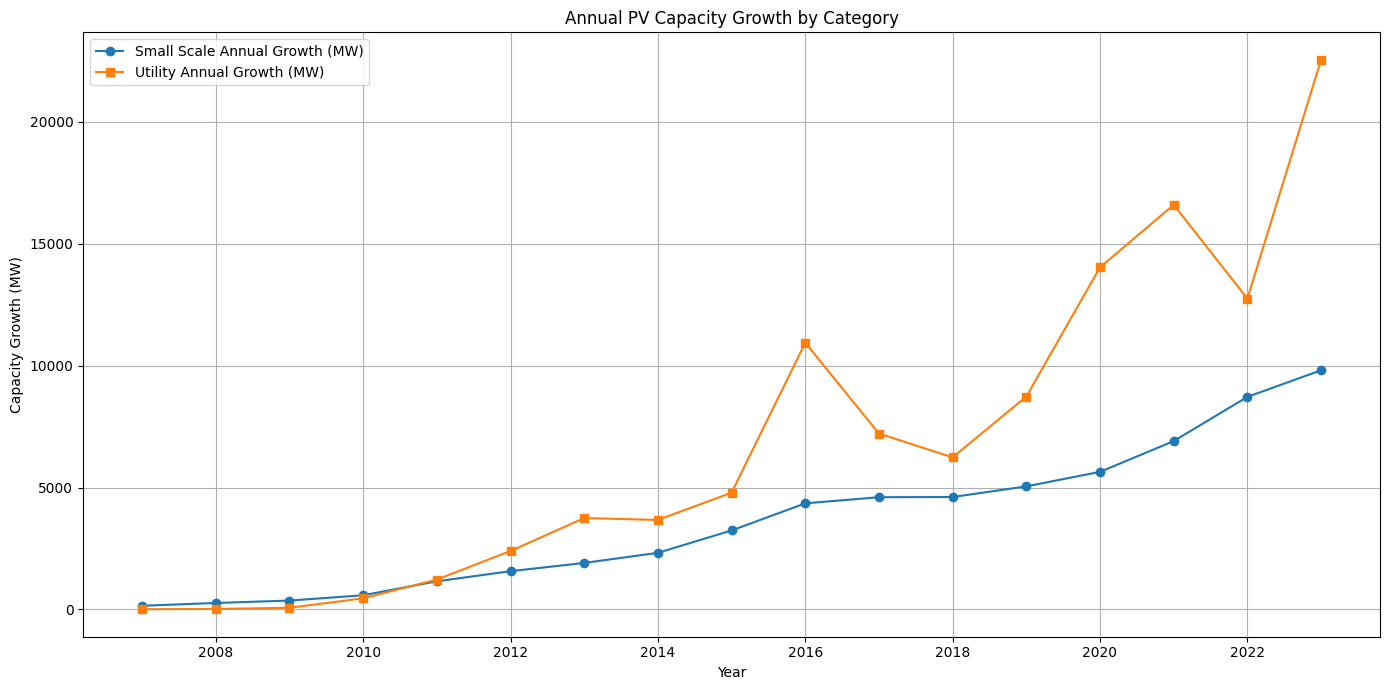

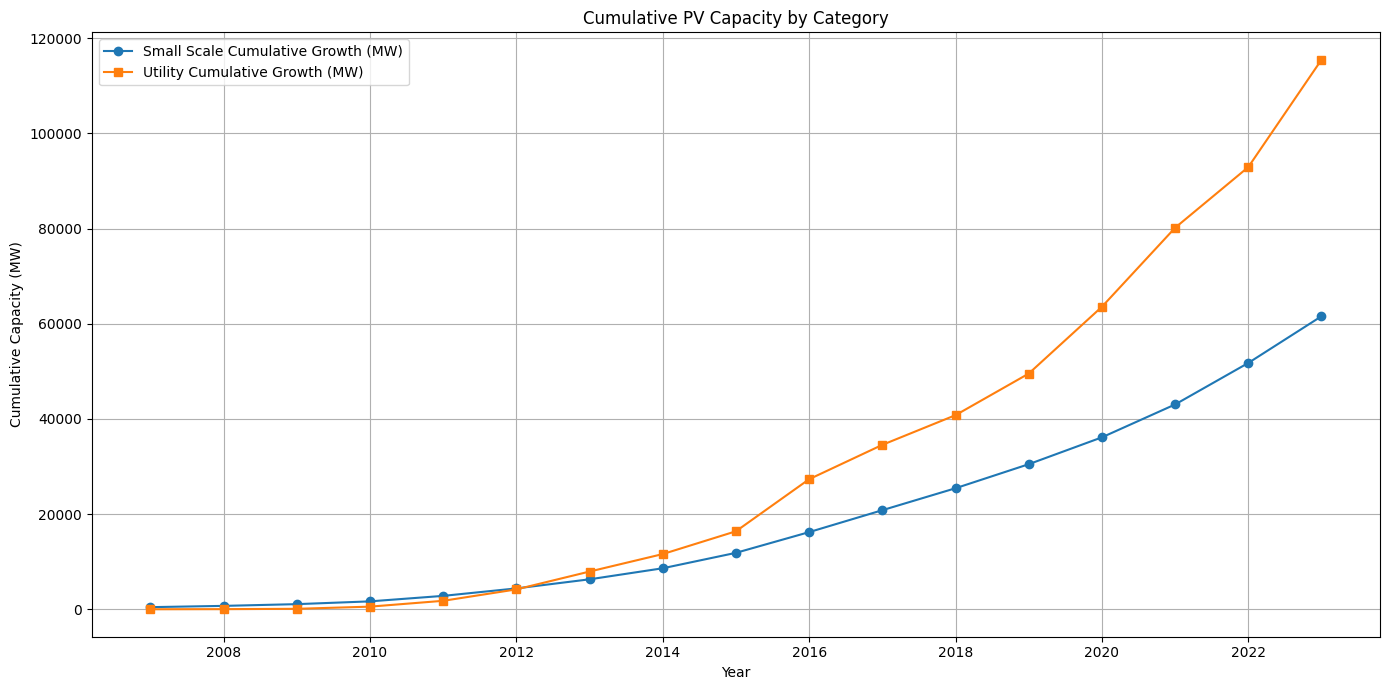

In [251]:
# Plot the annual growth
plt.figure(figsize=(14, 7))
plt.plot(years, small_scale_annual, label='Small Scale Annual Growth (MW)', marker='o')
plt.plot(years, utility_annual, label='Utility Annual Growth (MW)', marker='s')
plt.xlabel('Year')
plt.ylabel('Capacity Growth (MW)')
plt.title('Annual PV Capacity Growth by Category')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot the cumulative growth
plt.figure(figsize=(14, 7))
plt.plot(years, small_scale_cumul, label='Small Scale Cumulative Growth (MW)', marker='o')
plt.plot(years, utility_cumul, label='Utility Cumulative Growth (MW)', marker='s')
plt.xlabel('Year')
plt.ylabel('Cumulative Capacity (MW)')
plt.title('Cumulative PV Capacity by Category')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [252]:
def exp_func(x, a, b):
    return a * np.exp(b * x)

In [253]:
# Normalize the years to start from 0 for better numerical stability
normalized_years = years - years.min()

# Perform regression for small scale
params_small, _ = curve_fit(exp_func, normalized_years, small_scale_cumul, maxfev=10000)
small_scale_pred = exp_func(normalized_years, *params_small)

# Perform regression for utility
params_utility, _ = curve_fit(exp_func, normalized_years, utility_cumul, maxfev=10000)
utility_pred = exp_func(normalized_years, *params_utility)

# Calculate R-squared for small scale
residuals_small = small_scale_cumul - small_scale_pred
ss_res_small = np.sum(residuals_small**2)
ss_tot_small = np.sum((small_scale_cumul - np.mean(small_scale_cumul))**2)
r_squared_small = 1 - (ss_res_small / ss_tot_small)

# Calculate R-squared for utility
residuals_utility = utility_cumul - utility_pred
ss_res_utility = np.sum(residuals_utility**2)
ss_tot_utility = np.sum((utility_cumul - np.mean(utility_cumul))**2)
r_squared_utility = 1 - (ss_res_utility / ss_tot_utility)

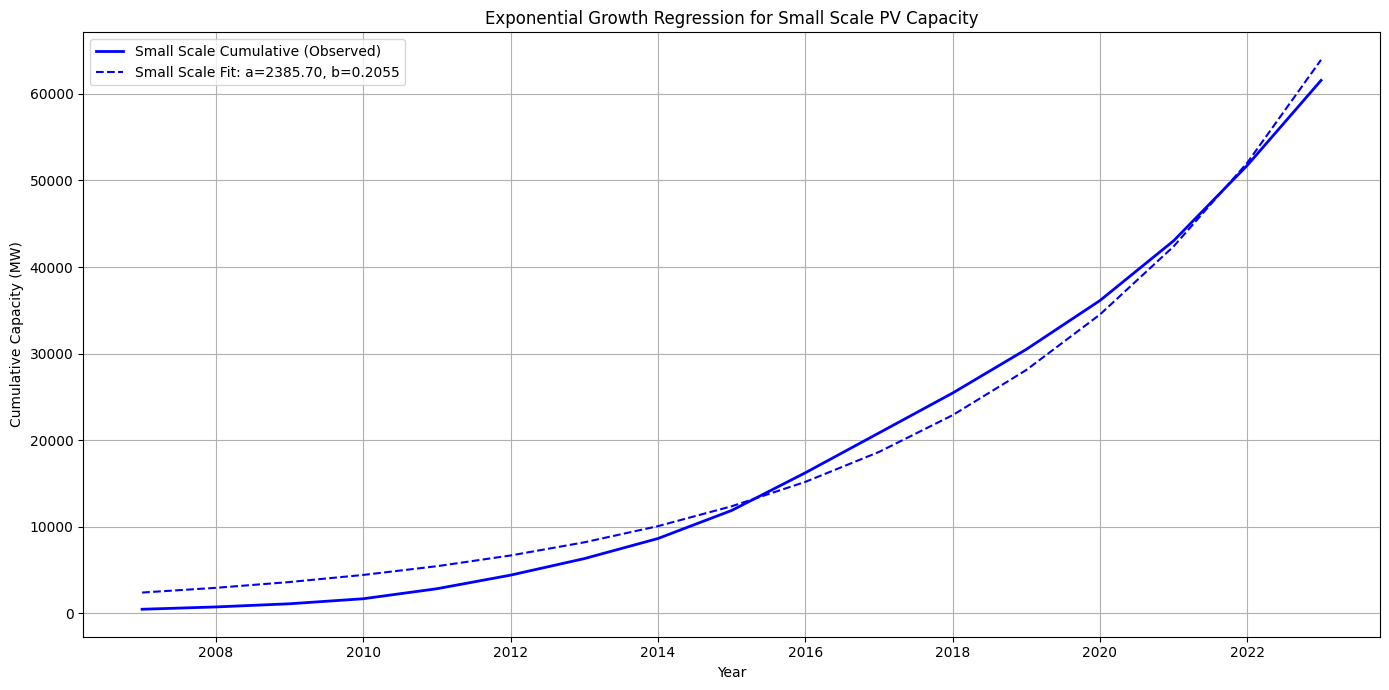

Small Scale PV Capacity:
  Growth Factor (a): 2385.70
  Growth Rate (b): 0.2055
  R-squared: 0.9889



In [254]:
# Plot the small scale cumulative graph
plt.figure(figsize=(14, 7))
plt.plot(years, small_scale_cumul, label='Small Scale Cumulative (Observed)', color='blue', linewidth=2)
plt.plot(years, small_scale_pred, label=f'Small Scale Fit: a={params_small[0]:.2f}, b={params_small[1]:.4f}', color='blue', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Cumulative Capacity (MW)')
plt.title('Exponential Growth Regression for Small Scale PV Capacity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print statistics for small scale
print("Small Scale PV Capacity:")
print(f"  Growth Factor (a): {params_small[0]:.2f}")
print(f"  Growth Rate (b): {params_small[1]:.4f}")
print(f"  R-squared: {r_squared_small:.4f}\n")

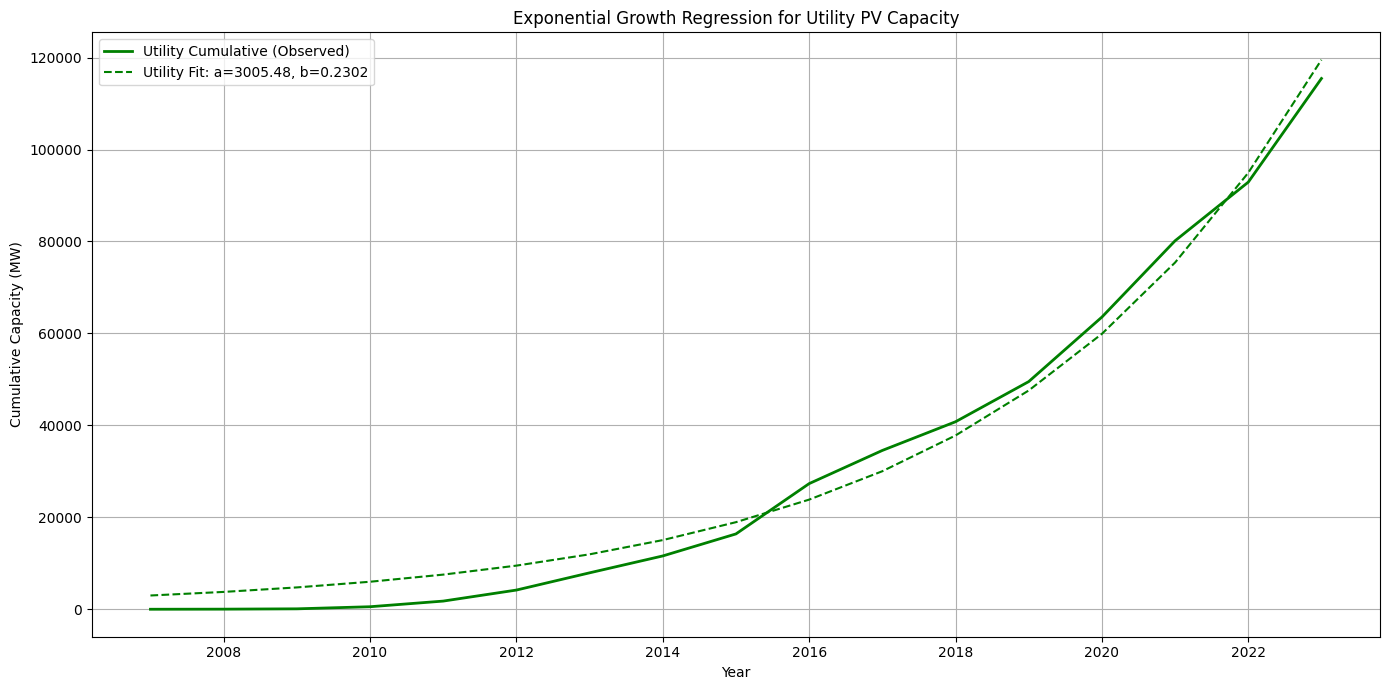

Utility PV Capacity:
  Growth Factor (a): 3005.48
  Growth Rate (b): 0.2302
  R-squared: 0.9873



In [255]:
# Plot the utility cumulative graph
plt.figure(figsize=(14, 7))
plt.plot(years, utility_cumul, label='Utility Cumulative (Observed)', color='green', linewidth=2)
plt.plot(years, utility_pred, label=f'Utility Fit: a={params_utility[0]:.2f}, b={params_utility[1]:.4f}', color='green', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Cumulative Capacity (MW)')
plt.title('Exponential Growth Regression for Utility PV Capacity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print statistics for utility
print("Utility PV Capacity:")
print(f"  Growth Factor (a): {params_utility[0]:.2f}")
print(f"  Growth Rate (b): {params_utility[1]:.4f}")
print(f"  R-squared: {r_squared_utility:.4f}\n")

### Exponential Growth of Utility PV Capacity

The utility-scale PV capacity exhibits exponential growth, characterized by a rapid increase in installed capacity over time. This growth is driven by technological advancements, decreasing costs, and favorable policy incentives, enabling large-scale solar installations to meet rising energy demands. The exponential regression model highlights a consistent growth rate, reflecting the scalability and efficiency of utility-scale solar systems in contributing to renewable energy goals.


### 3. Yearly Solar Generation

In [256]:
# Load the Excel file and the specific sheet
file_path = 'solar_data.xlsx'
sheet_name = 'solarbyyear'

# Read the Excel sheet into a Pandas DataFrame
yearly_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract relevant columns
yearly_data['Year'] = pd.to_datetime(yearly_data['Year'], format='%Y')  # Convert 'Year' to datetime
years_yr = yearly_data['Year']
utility_gen_yr = yearly_data['Utility Scale Generation']
small_scale_gen_yr = yearly_data['Small Scale Generation']
total_solar_yr = yearly_data['Total Solar']

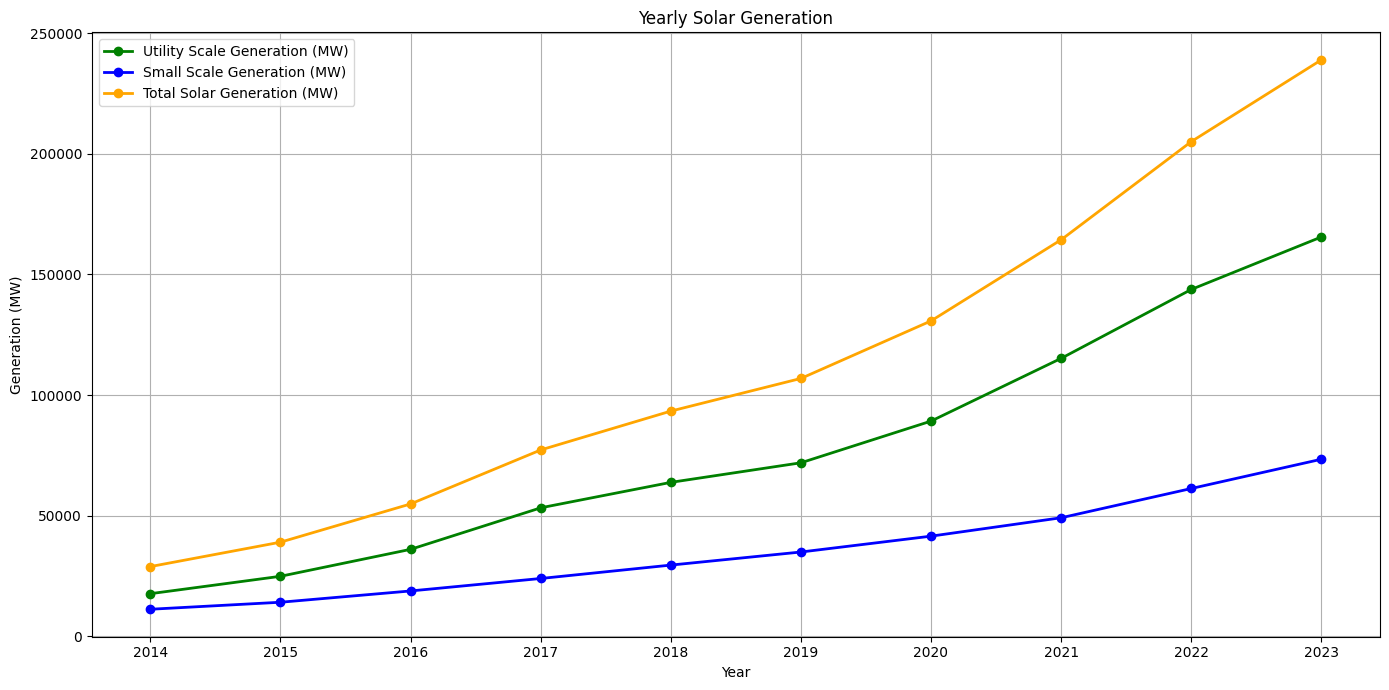

In [257]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(years_yr, utility_gen_yr, label='Utility Scale Generation (MW)', color='green', linewidth=2, marker='o')
plt.plot(years_yr, small_scale_gen_yr, label='Small Scale Generation (MW)', color='blue', linewidth=2, marker='o')
plt.plot(years_yr, total_solar_yr, label='Total Solar Generation (MW)', color='orange', linewidth=2, marker='o')
plt.xlabel('Year')
plt.ylabel('Generation (MW)')
plt.title('Yearly Solar Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Yearly Solar Generation Exclusion
The yearly solar generation was chosen to be excluded while training the model due to it's similar nature and significance to the solar capacity growth.

### 4. Solar Generation by Month

In [301]:
# Load the Excel file and the specific sheet
file_path = 'solar_data.xlsx'
sheet_name = 'solarbymonth'

# Read the Excel sheet into a Pandas DataFrame
monthly_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Extract relevant columns
monthly_data['Month'] = pd.to_datetime(monthly_data['Month'])  # Ensure the 'Month' column is in datetime format
months = monthly_data['Month']
utility_gen = monthly_data['Utility Scale Generation']
small_scale_gen = monthly_data['Small Scale Generation']
total_solar = monthly_data['Total Solar']

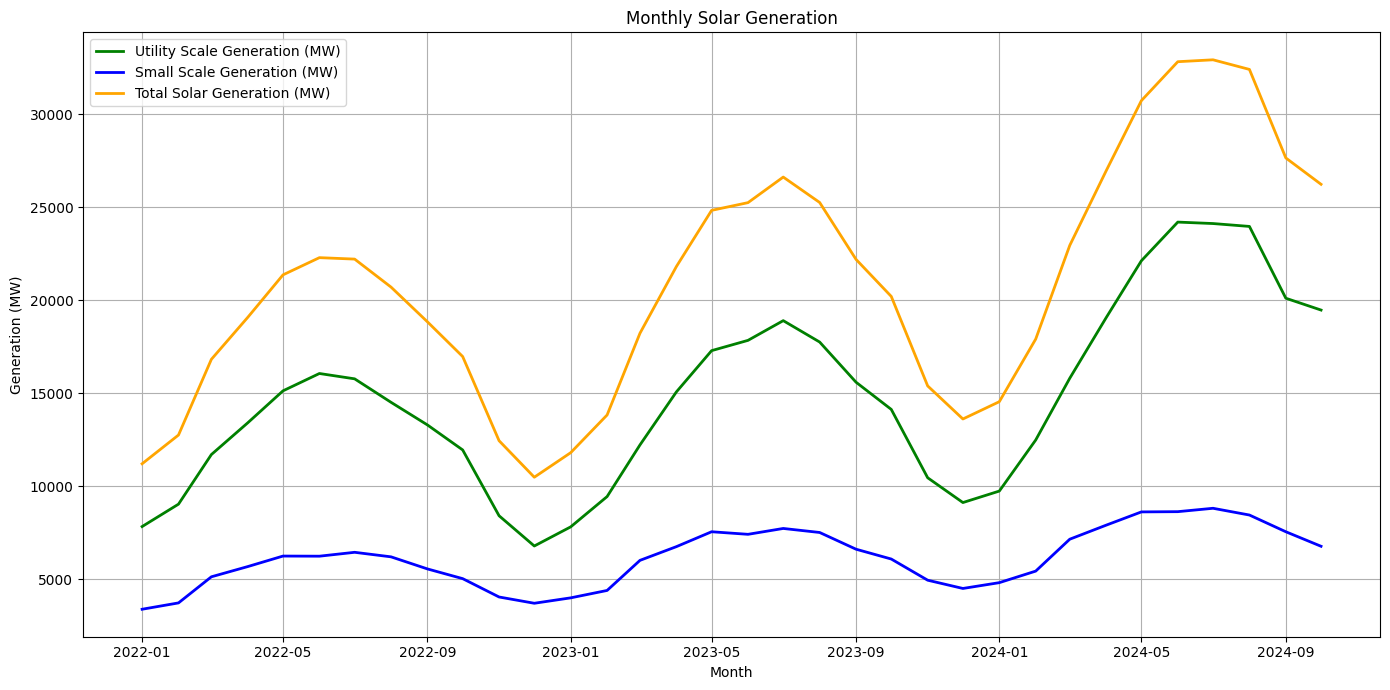

In [302]:
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(months, utility_gen, label='Utility Scale Generation (MW)', color='green', linewidth=2)
plt.plot(months, small_scale_gen, label='Small Scale Generation (MW)', color='blue', linewidth=2)
plt.plot(months, total_solar, label='Total Solar Generation (MW)', color='orange', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Generation (MW)')
plt.title('Monthly Solar Generation')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Monthly Solar Generation Trends

The monthly solar generation data displays a sinusoidal pattern, reflecting seasonal variations in solar energy production. Peaks in generation typically occur during summer months when sunlight is most abundant, while troughs are observed during winter due to shorter daylight hours and lower solar intensity. This cyclical behavior underscores the influence of natural seasonal changes on solar energy output and highlights the importance of integrating storage solutions to balance energy supply year-round.
